# Time Series In Python

In [20]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [21]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [22]:
# Get the first few rows
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


So we have 21 columns of data here. A lot of good information if you are doing some basic analysis for a client or at work. We have Who, What, Where and Why.

In [23]:
# How much of a time range do we have
# Use the Order date field and Min and Max function
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

We have a full 4 years of data starting from 2014 ending at the last business day of 2017.

## Dirty work
#### Cleaning data
This is the part of being an analyst that will never end. It's part of life, some people really like it, some people like me are not big fans. However if not done correctly you risk giving people even dirtier results in the end.

In [24]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 'Segment', 'Country', 
        'City', 'State', 'Postal Code', 'Region', 'Product ID', 
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 
        'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
# Time and Sales
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [25]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [26]:
# Set index 
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

To sum up our recent work we have indexed by date and grouped our dates together. Now we are going to do some more grouping this time by month. As you can see from the above dates we do not work everyday. The noise will be reduced with a monthly grouping for now.

Now this is where the fun starts. We are going to be typing 'y' soon!!!!

We are going to use Pandas to resample at month start (MS) and bring in the average.

In [27]:
y = furniture['Sales'].resample('MS').mean()

In [28]:
# Look at 2017 furniture sales data
y['2017']

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

### Time Series

Just a quick look above at 2017 and we see low sales to start the year and we see a rise in summer, with the 4th of July holiday we see a dip. During September we see an increase going into Q4.

Lets look at the entire series visually.

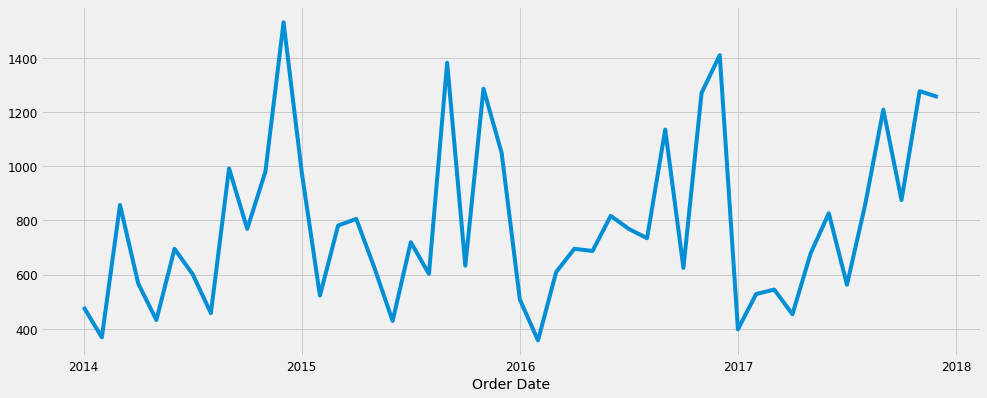

In [29]:
y.plot(figsize = (15, 6))
plt.show()

What can we gleen from this?

We see that the late Q3 into Q4 pattern shows up in all the years. We can also see a scant decline from 2014 through 2017.

### Things get a bit more technical from here

Let's try to keep it high level and explain if we need to.

We are going to visualize our data using a method called time-series decomposition. We are going to decompse our time series into three components: trend, seasonality, and noise.

I'm sure most will understand trend and seasonality, but noise? Heck someone who has been toying with time series since an undergrand has to look up what noise is.

Noise is what it sounds like, indeed it is noise. It comes from signal processing. Think about the snow you used to see on your television (not sure if snow is still around).

Bascially our observed data is hopefully based on something that is deterministic in nature. Well in time series we assume that the noise values are mutually uncorrelated with a zero mean and have some Gaussian distribution (I know we are in the weeds), in other words, that noise is white. Remeber the snow?


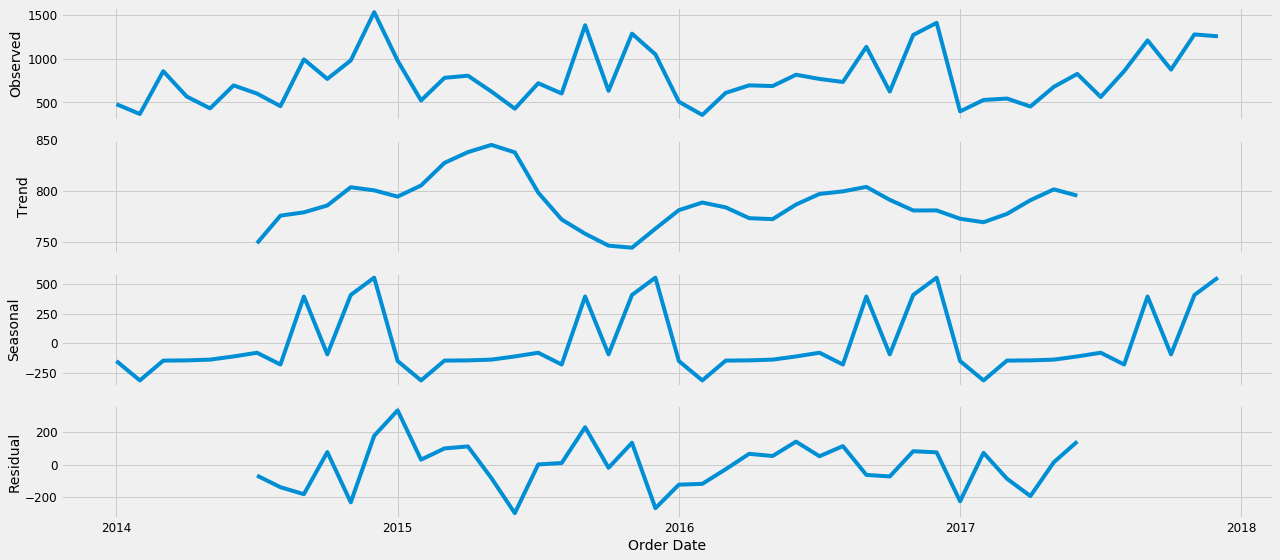

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

We have seasonality from our seasonal plot that is for sure. We can also see from the residual plot there is little pattern in place.

### Forecasting

#### Autogressive Integrated Moving Average or ARIMA

ARIMA, or Autoregressive Integrated Moving Average model is a common method used in time-series forecasting. One that I have used both in success and also some failure.

Models take the notation of ARIMA(p, d, q). The three parameters account for seasonality, trend and noise in data. Below we have some examples of parameter combinations for seasonal ARIMA.

In [31]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Let's look at the first example:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)

We have a model that contains a non-seasonal moving average (MA(1)) term, a seasonal MA(1) term, no auto regressive (AR) terms and the number of seasonal periods is 12.

I'll spare you the math and the greek letters that form the equation.

### Parameter Selection

Here we start selection of our parameters for the furniture sales ARIMA time series model. We will use a "grid search" to find the optimal set of parameters that gets the best performance. We use a grid search (fancy or better marketing term is hyperparameter optimzation) for model selection. After this chunk of code we will talk about evaluation of all these iterations.

In [32]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param,seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1468.2228748221485
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1100.5650593773883
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758102
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2724.644339605904
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809126
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5494840711955
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2584.564929289861
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468634
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1072.2139668408715
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1432.0290668139453
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817347
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2593.6381911085655
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484828693
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442639
ARI

#### Ok, what is this AIC thing we are seeing?

We need a metric to evaluate and compare the models we generated above. One method of doing this with ARIMA models is with the Akaike Information Criterion, or AIC. AIC is named for the statistician Hirotugu Akaike. Akaike introduced AIC at 1971 symposium. The formal paper later came in 1974 and has been cited a lot. Akaike's 1974 paper is one of the most cited papers ever.

The AIC shows how well a model fits taking in account the overall complexity of the model. A model that fits close to the data well while using lots of features will be assigned a larger AIC score than a model that uses few features to achive the same fit. With that known we want to find the model that yields the lowest AIC value.

#### Which model?
The above output would lead us to select the **SARIMAX(1, 1, 1)x(1, 1, 0, 12)** based on the **AIC value of 297.78**. We are going to consider this to be our optimal option.

## Fitting the SARIMA Model